# **Deforum Stable Diffusion**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team

Notebook by [deforum](https://twitter.com/deforum_art)

In [1]:
#@markdown **GPU**
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla V100-SXM2-16GB, 16160 MiB, 16160 MiB


In [2]:
#@markdown **Env Setup**

#@markdown Runtime > Restart Runtime
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install omegaconf==2.1.1 einops==0.3.0 pytorch-lightning==1.4.2 torchmetrics==0.6.0 torchtext==0.2.3 transformers==4.19.2 kornia==0.6
!git clone https://github.com/deforum/stable-diffusion -b dev
!pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
!pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |████████████████▎               | 834.1 MB 1.3 MB/s eta 0:10:04tcmalloc: large alloc 1147494400 bytes == 0x39174000 @  0x7f07f75aa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████▋           | 1055.7 MB 1.3 MB/s eta 0:07:43tcmalloc: large alloc 1434370048 bytes == 0x7d7ca000 @  0x7f07f75aa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████████████▏     | 

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 303 (delta 47), reused 41 (delta 35), pack-reused 223
Receiving objects: 100% (303/303), 68.51 MiB | 21.18 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-transformers
  Running command git clone -q https://github.com/CompVis/taming-transformers.git /content/src/taming-transformers
  Running setup.py develop for taming-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining clip from git+https://github.com/openai/CLIP.git@mai

In [1]:
#@markdown **Local Path Variables**
models_path = "/content/models" #@param {type:"string"}
output_path = "/content/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = True #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
  from google.colab import drive
  try:
    drive_path = "/content/drive"
    drive.mount(drive_path,force_remount=force_remount)
    models_path = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
  except:
    print("...error mounting drive or with drive path variables")
    print("...reverting to default path variables")
    models_path = "/content/models"
    output_path = "/content/output"

!mkdir -p $models_path
!mkdir -p $output_path

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [36]:
#@markdown **Python Definitions**
import json
from IPython import display
from tqdm.notebook import tqdm, trange

import sys, os
import argparse, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
#from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

sys.path.append('./stable-diffusion/')

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def get_output_folder(output_path,batch_folder=None):
  yearMonth = time.strftime('%Y-%m/')
  out_path = output_path+"/"+yearMonth
  if batch_folder != "":
    out_path += batch_folder
    if out_path[-1] != "/":
      out_path += "/"
  os.makedirs(out_path, exist_ok=True)
  return out_path

def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

def run(params):

    # outpath
    os.makedirs(params["outdir"], exist_ok=True)
    outpath = params["outdir"]

    # timestring
    timestring = time.strftime('%Y%m%d%H%M%S')

    # random seed
    if params["seed"] == -1:
      local_seed = np.random.randint(0,4294967295)
    else:
      local_seed = params["seed"]

    # save/append settings
    if params["save_settings"] and params["filename"] is None:
      filename = f"{timestring}_settings.txt"
      assert not os.path.isfile(f"{outpath}{filename}")
      params["filename"] = f"{timestring}_settings.txt"
      params["batch_seeds"] = [local_seed]
      with open(f"{outpath}{filename}", "w+") as f:
        json.dump(params, f, ensure_ascii=False, indent=4)
    elif params["save_settings"] and params["filename"] is not None:
      filename = params["filename"]
      with open(f"{outpath}{filename}") as f:
        params = json.load(f)
      params["batch_seeds"] += [local_seed]
      with open(f"{outpath}{filename}", "w+") as f:
        json.dump(params, f, ensure_ascii=False, indent=4)

    # load settings

    # seed
    seed_everything(local_seed)

    # plms
    if params["plms"]:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    batch_size = params["n_samples"]
    n_rows = params["n_rows"] if params["n_rows"] > 0 else batch_size
    if not params["from_file"]:
        prompt = params["prompt"]
        assert prompt is not None
        data = [batch_size * [prompt]]

    else:
        print(f"reading prompts from {from_file}")
        with open(from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    #sample_path = os.path.join(outpath, "samples")
    #os.makedirs(sample_path, exist_ok=True)
    #base_count = len(os.listdir(sample_path))
    base_count = 0
    #grid_count = len(os.listdir(outpath)) - 1

    start_code = None
    
    # init image
    if params["use_init"]:
      assert os.path.isfile(params["init_image"])
      init_image = load_img(params["init_image"]).to(device)
      init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
      init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

      sampler.make_schedule(ddim_num_steps=params['ddim_steps'], ddim_eta=params['ddim_eta'], verbose=False)
  
      assert 0. <= params['strength'] <= 1., 'can only work with strength in [0.0, 1.0]'
      t_enc = int(params['strength'] * params['ddim_steps'])
      print(f"target t_enc is {t_enc} steps")

    # no init image
    else:
      if params["fixed_code"]:
          start_code = torch.randn([params["n_samples"], params["C"], params["H"] // params["f"], params["W"] // params["f"]], device=device)

    precision_scope = autocast if params["precision"]=="autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                #for n in trange(params["n_iter"], desc="Sampling"):
                for n in range(params["n_iter"]):
                    #for prompts in tqdm(data, desc="data"):
                    for prompts in data:
                        uc = None
                        if params["scale"] != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        # no init image
                        if not params['use_init']:
                            shape = [params["C"], params["H"] // params["f"], params["W"] // params["f"]]
                            samples_ddim, _ = sampler.sample(S=params["ddim_steps"],
                                                            conditioning=c,
                                                            batch_size=params["n_samples"],
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=params["scale"],
                                                            unconditional_conditioning=uc,
                                                            eta=params["ddim_eta"],
                                                            x_T=start_code)

                            x_samples_ddim = model.decode_first_stage(samples_ddim)
                            x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
                            x_samples = x_samples_ddim

                        # init image
                        else:
                          # encode (scaled latent)
                          z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                          # decode it
                          samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=params['scale'],
                                                   unconditional_conditioning=uc,)
  
                          x_samples = model.decode_first_stage(samples)
                          x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
                        
                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            if params["display_samples"]:
                                display.display(Image.fromarray(x_sample.astype(np.uint8)))
                            if not params["skip_save"]:
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                      os.path.join(outpath, f"{timestring}_{base_count:02}.png"))
                            base_count += 1

                        if not params["skip_grid"]:
                            all_samples.append(x_samples)

                if not params["skip_grid"]:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    if params["display_grid"]:
                        display.display(Image.fromarray(grid.astype(np.uint8)))
                    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{timestring}_grid.png'))
                    #grid_count += 1

                toc = time.time()

    #print(f"Your samples are ready and waiting for you here: \n{outpath} \n" f" \nEnjoy.")

In [3]:
#@markdown **Model Path Variables**
# ask for the link
download_link = "" #@param {type:"string"}

# config
if os.path.exists(models_path+'/v1-inference.yaml'):
  print(f"{models_path+'/v1-inference.yaml'} exists")
else:
  print("cp ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml $models_path/.")
  !cp ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml $models_path/.

# weights 
if os.path.exists(models_path+'/v1-inference.ckpt'):
  print(f"{models_path+'/v1-inference.ckpt'} exists")
else:
  print(f"!wget -O $models_path/v1-inference.ckpt {download_link}")
  !wget -O $models_path/v1-inference.ckpt $download_link

config = models_path+'/v1-inference.yaml'
ckpt = models_path+'/v1-inference.ckpt'

print(f"config: {config}")
print(f"ckpt: {ckpt}")

/content/drive/MyDrive/AI/models/v1-inference.yaml exists
/content/drive/MyDrive/AI/models/v1-inference.ckpt exists
config: /content/drive/MyDrive/AI/models/v1-inference.yaml
ckpt: /content/drive/MyDrive/AI/models/v1-inference.ckpt


In [4]:
#@markdown **Load Stable Diffusion**

def load_model_from_config(config, ckpt, verbose=False, device='cuda'):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    #model.cuda()
    model = model.half().to(device)
    model.eval()
    return model

local_config = OmegaConf.load(f"{config}")
model = load_model_from_config(local_config, f"{ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

Loading model from /content/drive/MyDrive/AI/models/v1-inference.ckpt
Global Step: 440000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /root/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth


  0%|          | 0.00/5.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.23.self_attn.v_proj.weight', 'vision_model.encoder.layers.23.mlp.fc1.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.19.layer_norm2.bias', 'vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.bias', 'visual_projection.weight', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_mo

# **Run**

In [37]:
def opt_params():
  
  #@markdown **Save & Display Settings**
  batchdir = "new" #@param {type:"string"}
  outdir = get_output_folder(output_path,batchdir)
  save_settings = True #@param {type:"boolean"}
  skip_save = False #@param {type:"boolean"}
  skip_grid = True #@param {type:"boolean"}
  display_grid = False #@param {type:"boolean"}
  display_samples = True #@param {type:"boolean"}

  #@markdown **Prompt Settings**
  seed = -1 #@param
  prompt = "Bridget Riley" #@param {type:"string"}
  from_file = False #@param {type:"boolean"}

  #@markdown **Image Settings**
  n_samples = 1 #@param
  n_rows = 1 #@param
  W = 256 #@param
  H = 256 #@param

  #@markdown **Init Settings**
  use_init = False #@param {type:"boolean"}
  init_image = "/content/drive/MyDrive/AI/StableDiffusion/20220815180851_0.png" #@param {type:"string"}
  strength = 0.1 #@param {type:"number"}
  
  #@markdown **Sampling Settings**
  scale = 20 #@param
  n_iter = 1 #@param
  ddim_steps = 500 #@param
  ddim_eta = 0.0 #@param
  plms = False #@param {type:"boolean"}
  
  #@markdown **Batch Settings**
  n_batch = 20 #@param

  #@markdown **no idea what this does**
  precision = 'autocast' #@param
  fixed_code = True #@param
  C = 4 #@param
  f = 4 #@param

  return locals()

INFO:pytorch_lightning.utilities.seed:Global seed set to 335027973


run 1 of 20
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler:   0%|          | 0/500 [00:00<?, ?it/s]

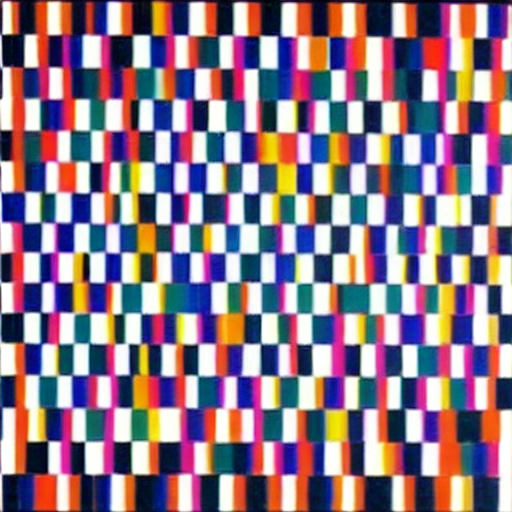

INFO:pytorch_lightning.utilities.seed:Global seed set to 2429438973


run 2 of 20
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [38]:
#@markdown **Run**
params = opt_params()
params["filename"] = None
for ii in range(params["n_batch"]):
  num = params["n_batch"]
  print(f"run {ii+1} of {num}")
  run(params)